<a href="https://colab.research.google.com/github/nhan2003h/Weather-forecasting/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install koalas
%pip install pyspark
%pip install numpy
%pip install pandas
%pip install matplotlib

In [ ]:
import glob
import os
import shutil

import pyspark
import numpy as np
import databricks.koalas as ks
import matplotlib.pyplot as plt

from pyspark import SparkContext, SparkConf

from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.tuning import CrossValidatorModel

from typing import *

In [ ]:
sc = SparkContext.getOrCreate()
sc.stop()
spark = SparkSession.builder.appName("dataMining").master("local[*]").config("spark.driver.memory", "128g").getOrCreate()

In [ ]:
DATASET_PATH: str = 'content/drive/data_mining/datasets/historical-hourly-weather/'
MODELS_PATH: str = 'content/drive/data_mining/models/historical-hourly-weather/'

RANDOM_SEED: int = 42

SLOW_OPERATIONS: bool = True

# True to save the computation of datataset preprocessing, fitted pipelines and trained models to the filesystem
SAVE_COMPUTATIONS: bool = True

# True to load the sampled dataset from the filesystem, False to compute it from the raw one
LOAD_SAMPLED_DATASET: bool = True
SAMPLED_DATASET_PATH: str = f'{DATASET_PATH}aggregated_sampled_weather_measurements.csv'

# True to load the encoding pipeline from the filesystem, False to compute it from scratch
LOAD_ECONDING_PIPELINE: bool = True
ENCODING_PIPELINE_PATH: str = f'{MODELS_PATH}data_encoder'

# True to load pretrained models from the filesystem, False to compute them from scratch
LOAD_PRETRAINED_MODELS: bool = True
RANDOM_FOREST_MODEL_PATH: str = f'{MODELS_PATH}rnd_forest'
RANDOM_FOREST_CROSS_VALIDATION_MODEL_PATH: str = f'{MODELS_PATH}rnd_forest_cv'
LOGISTIC_REGRESSION_CROSS_VALIDATION_MODEL_PATH: str = f'{MODELS_PATH}log_reg_cv'

# necessary due to DataBricks community edition limits (training on a dataframe larger than this threshold causes an Internal Server Error)
MAX_TRAIN_SIZE: int = 999_999

In [ ]:
!wget --no-verbose https://github.com/andrea-gasparini/big-data-weather-forecasting/raw/master/dataset/historical-hourly-weather-dataset.zip -O /tmp/dataset.zip
!unzip -u /tmp/dataset.zip -d /tmp/dataset

2024-04-10 06:55:13 URL:https://raw.githubusercontent.com/andrea-gasparini/big-data-weather-forecasting/master/dataset/historical-hourly-weather-dataset.zip [12655281/12655281] -> "/tmp/dataset.zip" [1]
Archive:  /tmp/dataset.zip
   creating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/._committed_7616641238230246128.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/.part-00000-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413e3b2b1a-5515-1-c000.csv.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/.part-00006-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413e3b2b1a-5521-1-c000.csv.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/.part-00002-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413e3b2b1a-5517-1-c000.csv.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/.part-00004-tid-5785058191

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
input_files = glob.glob(os.path.join('/tmp/dataset', "*"))
os.makedirs(DATASET_PATH, exist_ok=True)
for file in input_files:
    destination_path = f'{DATASET_PATH}/{os.path.basename(file)}'
    shutil.move(file, destination_path)

In [ ]:
weather_conditions_df = ks.read_csv(f'{DATASET_PATH}weather_description.csv')
humidity_df = ks.read_csv(f'{DATASET_PATH}humidity.csv')
pressure_df = ks.read_csv(f'{DATASET_PATH}pressure.csv')
temperature_df = ks.read_csv(f'{DATASET_PATH}temperature.csv')
city_attributes_df = ks.read_csv(f'{DATASET_PATH}city_attributes.csv')
wind_direction_df = ks.read_csv(f'{DATASET_PATH}wind_direction.csv')
wind_speed_df = ks.read_csv(f'{DATASET_PATH}wind_speed.csv')

In [ ]:
def print_dataframe_shape(dataframe: Union[DataFrame, ks.DataFrame]) -> None:

    if isinstance(dataframe, ks.DataFrame): dataframe = dataframe.to_spark()

    rows_count = dataframe.count()
    columns_count = len(dataframe.columns)

    print(f'The shape of the dataset is {rows_count} rows by {columns_count} columns', end='\n\n')

In [ ]:
DATETIME_COL = 'datetime'
HUMIDITY_COL = 'humidity'
PRESSURE_COL = 'pressure'
TEMPERATURE_COL = 'temperature'
WIND_DIRECTION_COL = 'wind_direction'
WIND_SPEED_COL = 'wind_speed'
LATITUDE_COL = 'latitude'
LONGITUDE_COL = 'longitude'
CITY_COL = 'city'
COUNTRY_COL = 'country'
WEATHER_CONDITION_COL = 'weather_condition'

In [ ]:
def filter_dataframe_by_city_column(dataframe: ks.DataFrame,
                                    city_name: str,
                                    new_column_name: str) -> DataFrame:
    '''
    Args:
        - dataframe: a `DataFrame` with a datetime column and n cities columns,
                     where the records are the related hourly measurements
        - city_name: city name between the ones in the dataframe
        - new_column_name: name to replace the city name

    Returns:
        a new `DataFrame` with:
            - the datetime column
            - a single column of measurements related to the `city_name`
              and renamed as `new_column_name`
    '''
    return dataframe.to_spark() \
        .withColumn(new_column_name, col(city_name)) \
        .select([DATETIME_COL, new_column_name])

In [ ]:
def join_dataframes(dataframes: List[DataFrame], column_name: str) -> DataFrame:
    '''
    Args:
        - dataframse: a list of `DataFrame` to be joined
        - column_name: the column over which the records should be joined

    Returns:
        a new dataframes resulting from the join of all the dataframes
        over the `column_name` column
    '''
    joined_df = dataframes[0]

    for dataframe in dataframes[1:]:
        joined_df = joined_df.join(dataframe, [column_name])

    return joined_df

In [ ]:
weather_measurements_df = None

# Iterate over all the records in the cities `DataFrame`
for index, row in city_attributes_df.iterrows():

    city = row.City
    country = row.Country
    latitude = row.Latitude
    longitude = row.Longitude

    # Compute a list of `DataFrame`, one for each type of measurement in the city
    dataframes = [
        filter_dataframe_by_city_column(humidity_df, city, HUMIDITY_COL),
        filter_dataframe_by_city_column(pressure_df, city, PRESSURE_COL),
        filter_dataframe_by_city_column(temperature_df, city, TEMPERATURE_COL),
        filter_dataframe_by_city_column(wind_direction_df, city, WIND_DIRECTION_COL),
        filter_dataframe_by_city_column(wind_speed_df, city, WIND_SPEED_COL),
        filter_dataframe_by_city_column(weather_conditions_df, city, WEATHER_CONDITION_COL)
    ]

    # Compute a `DataFrame` that includes all the data about the measurements in the city
    joined_df = join_dataframes(dataframes, DATETIME_COL) \
        .withColumn(CITY_COL, lit(city)) \
        .withColumn(COUNTRY_COL, lit(country)) \
        .withColumn(LATITUDE_COL, lit(latitude)) \
        .withColumn(LONGITUDE_COL, lit(longitude))

    # Union the `DataFrame` with the ones computed in the previous iterations
    weather_measurements_df = weather_measurements_df.union(joined_df) if weather_measurements_df is not None else joined_df


In [ ]:
# if SLOW_OPERATIONS:
#     for c in weather_measurements_df.columns:
#         print(f'Missing values of column `{c}` count: {weather_measurements_df.where(col(c).isNull()).count()}')

In [ ]:
def get_weather_conditions_aggregation_dict(weather_conditions: Iterable[str]) -> Dict[str, str]:
    '''
    Args:
        - weather_conditions: an iterable collection of string weather conditions to be aggregated

    Returns:
        a dictionary that goes from the original weather condition name to one among the following:
            - thunderstorm
            - rainy
            - snowy
            - cloudy
            - foggy
            - sunny
    '''

    weather_conditions_dict = dict()

    for weather_condition in weather_conditions:

        weather_condition_lowered = weather_condition.lower()

        if any(key in weather_condition_lowered for key in ['squall', 'thunderstorm']):
            weather_conditions_dict[weather_condition] = 'thunderstorm'
        elif any(key in weather_condition_lowered for key in ['drizzle', 'rain']):
            weather_conditions_dict[weather_condition] = 'rainy'
        elif any(key in weather_condition_lowered for key in ['sleet', 'snow']):
            weather_conditions_dict[weather_condition] = 'snowy'
        elif 'cloud' in weather_condition_lowered:
            weather_conditions_dict[weather_condition] = 'cloudy'
        elif any(key in weather_condition_lowered for key in ['fog', 'mist', 'haze']):
            weather_conditions_dict[weather_condition] = 'foggy'
        elif any(key in weather_condition_lowered for key in ['clear', 'sun']):
            weather_conditions_dict[weather_condition] = 'sunny'

    return weather_conditions_dict


In [ ]:
not_null_weather_measurements_df = weather_measurements_df.dropna()


In [ ]:
weather_conditions_all = not_null_weather_measurements_df \
    .select(WEATHER_CONDITION_COL).distinct() \
    .to_koalas().to_numpy().reshape(-1)

In [ ]:
weather_conditions_dict = get_weather_conditions_aggregation_dict(weather_conditions_all)

In [ ]:
weather_measurements_aggregated_df = not_null_weather_measurements_df.replace(weather_conditions_dict)

In [ ]:
WEATHER_CONDITIONS = set(weather_conditions_dict.values())

weather_measurements_aggregated_df = weather_measurements_aggregated_df \
    .filter(weather_measurements_aggregated_df[WEATHER_CONDITION_COL].isin(WEATHER_CONDITIONS))

In [ ]:
def count_weather_condition_occurrences(dataframe: DataFrame, class_name: str) -> int:
    '''
    Args:
        - dataframe: a `DataFrame` which contains a column `WEATHER_CONDITION_COL`
        - class_name: the class name to count the occurences of

    Returns:
        the total number of `class_name` occurences inside `dataframe`
    '''
    return dataframe.filter(dataframe[WEATHER_CONDITION_COL] == class_name).count()

In [ ]:
def get_undersampling_fracs(dataframe: DataFrame) -> Dict[str, float]:
    '''
    Args:
        - dataframe: a `DataFrame` of weather measurements which contains a column `WEATHER_CONDITION_COL`

    Returns:
        a dictionary that goes from a weather condition to its fraction
        that should be sampled in order to match the occurences of the minority class
    '''

    rainy_cnt = count_weather_condition_occurrences(dataframe, 'rainy')
    snowy_cnt = count_weather_condition_occurrences(dataframe, 'snowy')
    sunny_cnt = count_weather_condition_occurrences(dataframe, 'sunny')
    foggy_cnt = count_weather_condition_occurrences(dataframe, 'foggy')
    cloudy_cnt = count_weather_condition_occurrences(dataframe, 'cloudy')
    thunderstorm_cnt = count_weather_condition_occurrences(dataframe, 'thunderstorm')

    minority_class_cnt = np.min([rainy_cnt, snowy_cnt, sunny_cnt, cloudy_cnt, foggy_cnt, thunderstorm_cnt])

    return {
        'rainy': minority_class_cnt / rainy_cnt,
        'snowy': minority_class_cnt / snowy_cnt,
        'sunny': minority_class_cnt / sunny_cnt,
        'foggy': minority_class_cnt / foggy_cnt,
        'cloudy': minority_class_cnt / cloudy_cnt,
        'thunderstorm': minority_class_cnt / thunderstorm_cnt
    }

In [ ]:
sampled_weather_measurements_df = ks.read_csv(SAMPLED_DATASET_PATH).to_spark() if LOAD_SAMPLED_DATASET \
                                  else not_null_weather_measurements_df.sampleBy(WEATHER_CONDITION_COL,
                                                                                 fractions=get_undersampling_fracs(not_null_weather_measurements_df),
                                                                                 seed=RANDOM_SEED)

In [ ]:
if SAVE_COMPUTATIONS and not LOAD_SAMPLED_DATASET:
    sampled_weather_measurements_df.write.csv(SAMPLED_DATASET_PATH,
                                              mode='overwrite',
                                              header=True)

In [ ]:
# sampled_weather_measurements_df.describe().to_koalas().transpose()

In [ ]:
train_df, test_df = sampled_weather_measurements_df.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

In [ ]:
# necessary due to DataBricks limits (training on a dataframe larger than this threshold causes an Internal Server Error)
train_df = train_df.limit(MAX_TRAIN_SIZE)

In [ ]:

print(f'Train set size:  {train_df.count()} instances')
print(f'Test set size:   {test_df.count()} instances')

Train set size:  41230 instances
Test set size:   10199 instances


In [ ]:
NUMERICAL_FEATURES = [HUMIDITY_COL,
                      PRESSURE_COL,
                      TEMPERATURE_COL,
                      WIND_DIRECTION_COL,
                      WIND_SPEED_COL,
                      LATITUDE_COL,
                      LONGITUDE_COL]

CATEGORICAL_FEATURES = []

TARGET_VARIABLE_COL = WEATHER_CONDITION_COL
PREDICTED_TARGET_VARIABLE_COL = f'predicted_{TARGET_VARIABLE_COL}'

LABEL_COL = 'label'
PREDICTION_COL = 'prediction'

FEATURES_COL = 'features'
SCALED_FEATURES_COL = f'scaled_{FEATURES_COL}'

In [ ]:
def save_pyspark_model(model, path: str, append_datetime: bool = True) -> None:

    if append_datetime:
        from datetime import datetime
        path += '-' + datetime.now().strftime("%Y%d%m-%H%M%S")

    model.write().overwrite().save(path)

In [ ]:
def encoding_pipeline(dataframe: DataFrame,
                      numerical_features: List[str],
                      categorical_features: List[str],
                      target_variable: str,
                      with_std: bool = True,
                      with_mean: bool = False) -> PipelineModel:
    '''
    Args:
        - dataframe: the input `DataFrame` to fit the pipeline
        - numerical_features: the list of column names in `dataframe` corresponding to numerical features
        - categorical_features: the list of column names in `dataframe` corresponding to categorical features
        - target_variable: the column name in `dataframe` corresponding to the target variable
        - with_std: whether to scale the data to unit standard deviation or not (True by default)
        - with_mean: whether to center the data with mean before scaling (False by default)

    Returns:
        the encoding pipeline fitted with `dataframe`
    '''

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

    # Indexing, i.e. transform to numerical values, the target column and rename it as the variable `LABEL_COL`
    label_indexer = StringIndexer(inputCol=target_variable, outputCol=LABEL_COL)

    # Create a list of indexers, one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol=f'{c}_indexed', handleInvalid='keep') for c in categorical_features]

    # Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers],
                            outputCols=[f'{indexer.getOutputCol()}_encoded' for indexer in indexers],
                            handleInvalid='keep')

    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    features = encoder.getOutputCols() + numerical_features
    assembler = VectorAssembler(inputCols=features, outputCol=FEATURES_COL)

    # Create a second feature column with the data scaled accordingly to `withStd` and `withMean`
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol=SCALED_FEATURES_COL, withStd=with_std, withMean=with_mean)

    stages = [label_indexer] + indexers + [encoder] + [assembler] + [scaler]
    pipeline = Pipeline(stages=stages)

    transformer = pipeline.fit(dataframe)

    return transformer


In [ ]:
# data_encoder = PipelineModel.load(ENCODING_PIPELINE_PATH) if LOAD_ECONDING_PIPELINE \
#                else encoding_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE_COL)
data_encoder = encoding_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE_COL)

In [ ]:
if SAVE_COMPUTATIONS and not LOAD_ECONDING_PIPELINE:
    save_pyspark_model(data_encoder, ENCODING_PIPELINE_PATH)

In [ ]:
encoded_train_df = data_encoder.transform(train_df)
encoded_test_df = data_encoder.transform(test_df)

In [ ]:
encoded_train_df.select([FEATURES_COL, SCALED_FEATURES_COL, LABEL_COL]).show(5)


+--------------------+--------------------+-----+
|            features|     scaled_features|label|
+--------------------+--------------------+-----+
|[93.0,1015.0,281....|[4.49744891584403...|  0.0|
|[72.0,1015.0,284....|[3.48189593484699...|  1.0|
|[93.0,1015.0,281....|[4.49744891584403...|  0.0|
|[76.0,1011.0,284....|[3.67533459789404...|  0.0|
|[74.0,1010.0,286....|[3.57861526637052...|  1.0|
+--------------------+--------------------+-----+
only showing top 5 rows



In [ ]:
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel

# rnd_forest_model = RandomForestClassificationModel.load(RANDOM_FOREST_MODEL_PATH) if LOAD_PRETRAINED_MODELS \
#                    else RandomForestClassifier(featuresCol=FEATURES_COL, labelCol=LABEL_COL).fit(encoded_train_df)
rnd_forest_model = RandomForestClassifier(featuresCol=FEATURES_COL, labelCol=LABEL_COL).fit(encoded_train_df)


In [ ]:
rnd_forest_predictions = rnd_forest_model.transform(encoded_test_df)

In [ ]:
from pyspark.ml.feature import IndexToString

predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                       outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                       labels=data_encoder.stages[0].labels)

In [ ]:
rnd_forest_predictions = predictions_idx_to_str.transform(rnd_forest_predictions)


In [ ]:
def eval_predictions(predictions: DataFrame) -> None:

    from sklearn.metrics import precision_score, recall_score, accuracy_score

    labels = predictions.select(LABEL_COL).to_koalas().to_numpy()
    predictions = predictions.select(PREDICTION_COL).to_koalas().to_numpy()

    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1_score = 2 * precision * recall / (precision + recall)
    accuracy = accuracy_score(labels, predictions)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1_score}')

In [ ]:
eval_predictions(rnd_forest_predictions)


Accuracy: 0.5122070791254044
Precision: 0.4873210110158865
Recall: 0.5081167703280439
F1-score: 0.4975016678512756


In [ ]:
def plot_confusion_matrix(predictions_df: DataFrame,
                          normalize: bool = False,
                          title: str = None):
    '''
    Plots a Confusion Matrix computed on the given `DataFrame`

    Args:
        - predictions_df: a `DataFrame` that has at least a `TARGET_VARIABLE_COL` and a `PREDICTED_TARGET_VARIABLE_COL`
        - normalize: True to normalize the values in the Confusion Matrix, False otherwise
        - title: optional title to append on top of the plotted Confusion Matrix
    '''

    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels

    labels = predictions_df.select(TARGET_VARIABLE_COL).to_koalas().to_numpy()
    pedictions = predictions_df.select(PREDICTED_TARGET_VARIABLE_COL).to_koalas().to_numpy()

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(labels, pedictions, labels=None)

    # Only use the labels that appear in the data
    classes = unique_labels(labels, pedictions)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           xlabel='Predicted label', ylabel='True label',
           title=title)

    ax.set_ylim(len(classes) - 0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

    fig.tight_layout()
    plt.show()

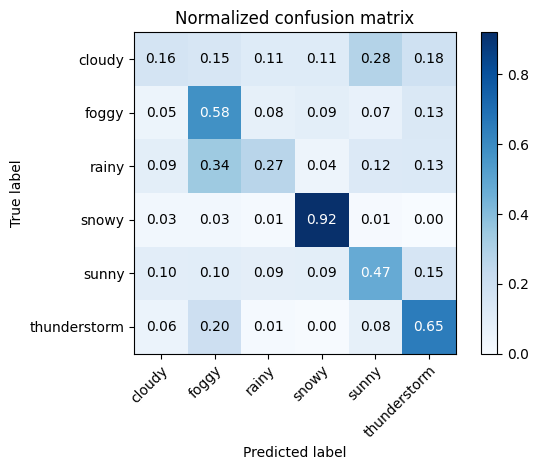

In [ ]:
plot_confusion_matrix(rnd_forest_predictions, normalize=True)


In [ ]:
if SAVE_COMPUTATIONS and not LOAD_PRETRAINED_MODELS:
    save_pyspark_model(rnd_forest_model, RANDOM_FOREST_MODEL_PATH)

In [ ]:
def random_forest_pipeline(dataframe: DataFrame,
                           numerical_features: List[str],
                           categorical_features: List[str],
                           target_variable: str,
                           features_col: str,
                           with_std: bool = True,
                           with_mean: bool = False,
                           k_fold: int = 5) -> CrossValidatorModel:

    from pyspark.ml.classification import RandomForestClassifier
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    from pyspark.ml.feature import IndexToString
    from pyspark.ml import Pipeline

    data_encoder = encoding_pipeline(dataframe,
                                     numerical_features,
                                     categorical_features,
                                     target_variable,
                                     with_std,
                                     with_mean)

    classifier = RandomForestClassifier(featuresCol=features_col, labelCol=LABEL_COL)

    predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                           outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                           labels=data_encoder.stages[0].labels)

    stages = [data_encoder, classifier, predictions_idx_to_str]

    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for maxDepth and 3 values for numTrees
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder() \
        .addGrid(classifier.maxDepth, [3, 5, 8]) \
        .addGrid(classifier.numTrees, [10, 50, 100]) \
        .build()

    evaluator = MulticlassClassificationEvaluator(labelCol=LABEL_COL,
                                                  predictionCol=PREDICTION_COL,
                                                  metricName='accuracy')

    cross_val = CrossValidator(estimator=pipeline,
                               estimatorParamMaps=param_grid,
                               evaluator=evaluator,
                               numFolds=k_fold,
                               collectSubModels=True)

    cv_model = cross_val.fit(dataframe)

    return cv_model

In [ ]:
# rnd_forest_cv_model = CrossValidatorModel.load(RANDOM_FOREST_CROSS_VALIDATION_MODEL_PATH) if LOAD_PRETRAINED_MODELS \
#                       else random_forest_pipeline(train_df,
#                                                   NUMERICAL_FEATURES,
#                                                   CATEGORICAL_FEATURES,
#                                                   TARGET_VARIABLE_COL,
#                                                   FEATURES_COL)
rnd_forest_cv_model = random_forest_pipeline(train_df,
                                            NUMERICAL_FEATURES,
                                            CATEGORICAL_FEATURES,
                                            TARGET_VARIABLE_COL,
                                            FEATURES_COL)

In [ ]:
rnd_forest_cv_model_obj = rnd_forest_cv_model.bestModel.stages[-2]._java_obj

print('Best model according to k-fold cross validation:')
print(f' - numTrees=[{rnd_forest_cv_model_obj.getNumTrees()}]')
print(f' - maxDepth=[{rnd_forest_cv_model_obj.getMaxDepth()}]')

Best model according to k-fold cross validation:
 - numTrees=[100]
 - maxDepth=[8]


In [ ]:
if SAVE_COMPUTATIONS and not LOAD_PRETRAINED_MODELS:
    save_pyspark_model(rnd_forest_cv_model, RANDOM_FOREST_CROSS_VALIDATION_MODEL_PATH)

In [ ]:
rnd_forest_cv_predictions = rnd_forest_cv_model.transform(test_df)


In [ ]:
eval_predictions(rnd_forest_cv_predictions)


Accuracy: 0.5420139229336209
Precision: 0.5207858464894176
Recall: 0.5388572863340392
F1-score: 0.5296674688066283


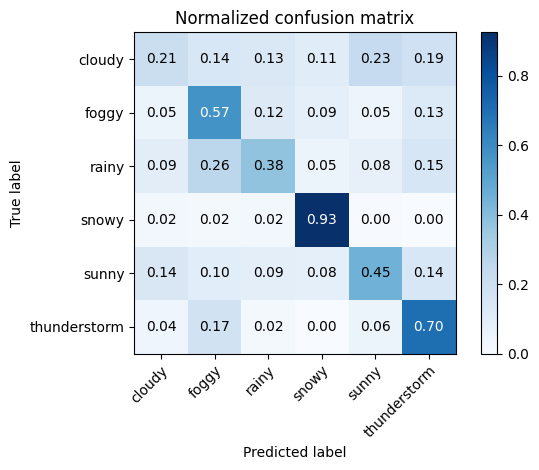

In [ ]:
plot_confusion_matrix(rnd_forest_cv_predictions, normalize=True)


**Decision Tree Model**

In [ ]:
classifier = DecisionTreeClassifier(
    featuresCol = 'scaled_features',
    labelCol = 'label',
    maxDepth = 10
)

In [ ]:
pipeline = Pipeline(stages = [data_encoder, classifier])


In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol = 'label',
    predictionCol = 'prediction',
    metricName = 'accuracy'
)

In [ ]:
# Define the grid of hyperparameters
param_grid = ParamGridBuilder().build()

# Set up the cross validator for model training and hyperparameter tuning
cross_validator = CrossValidator(
    estimator = pipeline,
    estimatorParamMaps = param_grid,
    evaluator = evaluator,
    numFolds = 5
)

In [ ]:
model = cross_validator.fit(train_df)

In [ ]:
predictions = model.transform(test_df)

In [ ]:
eval_predictions(predictions)


**Multilayer Perceptron**

In [ ]:
layers = [len(NUMERICAL_FEATURES) + len(CATEGORICAL_FEATURES), 32, 64, 128, 6]

In [ ]:
classifier = MultilayerPerceptronClassifier(
    featuresCol = 'scaled_features',
    labelCol = 'label',
    maxIter = 500,
    layers = layers,
    blockSize = 128,
    seed = 42,
)

In [ ]:
pipeline = Pipeline(stages = [data_encoder, classifier])

In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol = 'label',
    predictionCol = 'prediction',
    metricName = 'accuracy'
)

In [ ]:
# Define the grid of hyperparameters
param_grid = ParamGridBuilder().build()

# Set up the cross validator for model training and hyperparameter tuning
cross_validator = CrossValidator(
    estimator = pipeline,
    estimatorParamMaps = param_grid,
    evaluator = evaluator,
    numFolds = 5
)

In [ ]:
model = cross_validator.fit(train_df)

In [ ]:
predictions = model.transform(test_df)

In [ ]:
dt_predictions = predictions_idx_to_str.transform(predictions)
plot_confusion_matrix(dt_predictions, normalize = True)

**Compare with Open Weather API**

In [ ]:
API_KEY = '20d64175b45f6cdedff241d5ebc82d4a'
CITY_NAMES = ['Vancouver']

openweather_model = rnd_forest_cv_model

OPENWEATHER_FORECAST_COL = 'openweather_forecast'

In [ ]:
def get_5_days_forecasts_df(city_name: str, api_key: str) -> ks.DataFrame:

    import requests

    API_URL = f'http://api.openweathermap.org/data/2.5/forecast?q={city_name}&appid={api_key}'

    res = requests.get(API_URL).json()

    coord = res['city']['coord']

    latitude = float(coord['lat'])
    longitude = float(coord['lon'])

    WeatherForecast = Row(DATETIME_COL,
                          HUMIDITY_COL,
                          PRESSURE_COL,
                          TEMPERATURE_COL,
                          WIND_DIRECTION_COL,
                          WIND_SPEED_COL,
                          TARGET_VARIABLE_COL,
                          CITY_COL,
                          LATITUDE_COL,
                          LONGITUDE_COL)

    forecasts = list()

    for forecast in res['list']:

        main = forecast['main']
        wind = forecast['wind']
        weather = forecast['weather']

        datetime = forecast['dt_txt']

        temperature = float(main['temp'])
        pressure = float(main['pressure'])
        humidity = float(main['humidity'])
        wind_speed = float(wind['speed'])
        wind_direction = float(wind['deg'])

        weather_condition = weather[0]['main']

        forecast_row = WeatherForecast(datetime,
                                       humidity,
                                       pressure,
                                       temperature,
                                       wind_direction,
                                       wind_speed,
                                       weather_condition,
                                       city_name,
                                       latitude,
                                       longitude)

        forecasts.append(forecast_row)

    return spark.createDataFrame(forecasts).to_koalas()


In [ ]:
openweather_forecasts_df = ks.concat([get_5_days_forecasts_df(city_name, API_KEY) for city_name in CITY_NAMES])

In [ ]:
weather_conditions = openweather_forecasts_df[TARGET_VARIABLE_COL].to_numpy()
weather_conditions_dict = get_weather_conditions_aggregation_dict(weather_conditions)

In [ ]:
openweather_forecasts_df = openweather_forecasts_df.to_spark().replace(weather_conditions_dict)

In [ ]:
openweather_forecasts_df = openweather_forecasts_df.filter(openweather_forecasts_df[TARGET_VARIABLE_COL].isin(WEATHER_CONDITIONS))

In [ ]:
openweather_forecasts_df.to_koalas().head(5)

In [ ]:
openweather_forecasts_predictions = openweather_model.transform(openweather_forecasts_df)

In [ ]:
openweather_forecasts_predictions \
    .withColumn(OPENWEATHER_FORECAST_COL, col(TARGET_VARIABLE_COL)) \
    .select([DATETIME_COL, CITY_COL, OPENWEATHER_FORECAST_COL, PREDICTED_TARGET_VARIABLE_COL]) \
    .to_koalas().head(15)

In [ ]:
plot_confusion_matrix(openweather_forecasts_predictions, normalize=True)